In [66]:
from pathlib import Path
import albumentations as albu
import cv2
import numpy as np
import torch
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from iglovikov_helper_functions.utils.image_utils import pad, unpad
from torch import nn
from iglovikov_helper_functions.dl.pytorch.utils import rename_layers
from segmentation_models_pytorch import Unet
from matplotlib import pyplot as plt
from PIL import Image

In [117]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def test_augmentations(MAX_SIZE=512):
    transform = albu.Compose(
        [albu.LongestMaxSize(max_size=MAX_SIZE), albu.Normalize(p=1)], p=1
    )
    return albu.Compose(transform)

In [114]:
def load_model(model_path):
    model=Unet(encoder_name="timm-efficientnet-b3", classes=1, encoder_weights=None)
    state_dict = torch.load(model_path)["state_dict"]
    state_dict = rename_layers(state_dict, {"model.": ""})
    model.load_state_dict(state_dict)
    return model

model = load_model('unet-timm-efficient-b3.pth')
model.eval()
model.name

'u-timm-efficientnet-b3'

In [129]:
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
transform = test_augmentations()
model = model.to(device)

# Use 16 bit
model = model.half()

def predict(image_path, MAX_SIZE=512):
    original_image = np.array(Image.open(image_path))
    original_height, original_width = original_image.shape[:2]
    image = transform(image=original_image)["image"]
    padded_image, pads = pad(image, factor=MAX_SIZE, border=cv2.BORDER_CONSTANT)

    with torch.no_grad():
        x = torch.unsqueeze(tensor_from_rgb_image(padded_image), 0).half()
        prediction = model(x.to(device))[0][0]

    mask = (prediction > 0).cpu().numpy().astype(np.uint8)
    mask = unpad(mask, pads)
    mask = cv2.resize(
        mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST
    )
    mask_3_channels = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    dst = cv2.addWeighted(
        original_image, 1, (mask_3_channels * (0, 255, 0)).astype(np.uint8), 0.5, 0
    )

    visualize(image=original_image, mask=mask*255, dst = dst) 

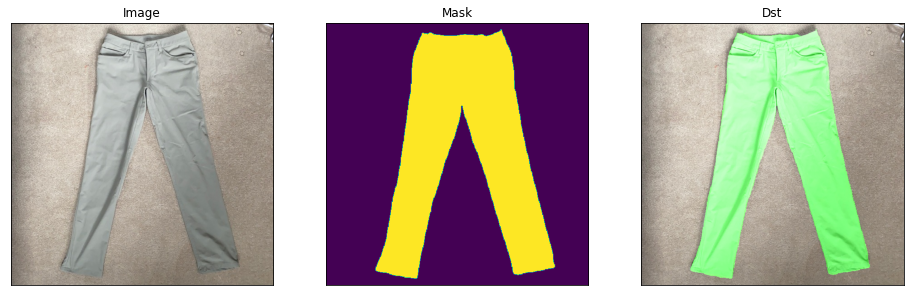

In [130]:
predict('sample_images/Bottoms/Mens_Pants.jpeg')

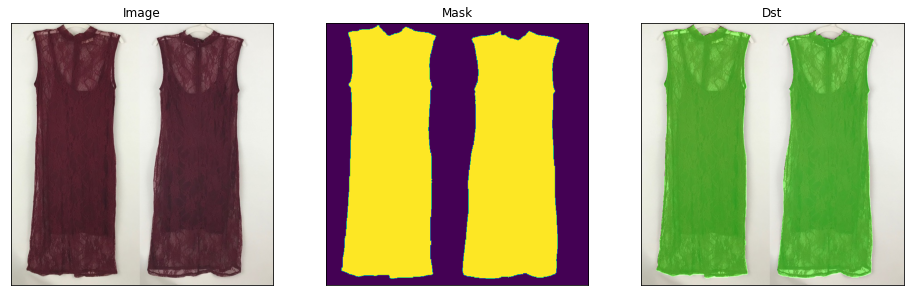

In [131]:
predict('sample_images/Tops/Dress.jpeg')

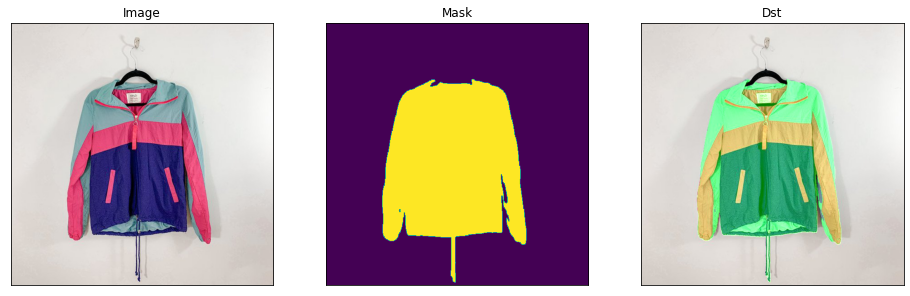

In [132]:
predict('sample_images/Tops/Jacket.jpeg')

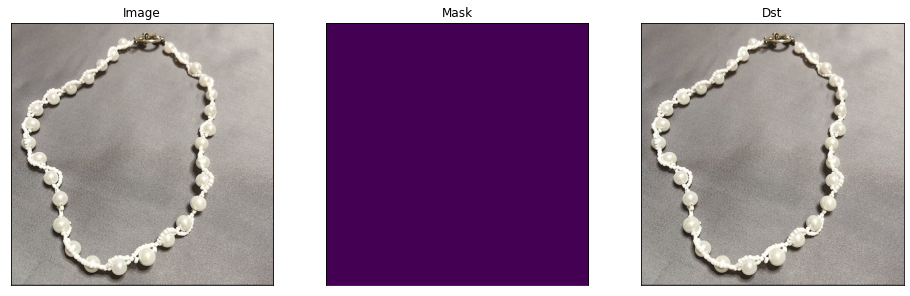

In [133]:
predict('sample_images/Jewelry/Necklace.jpeg')

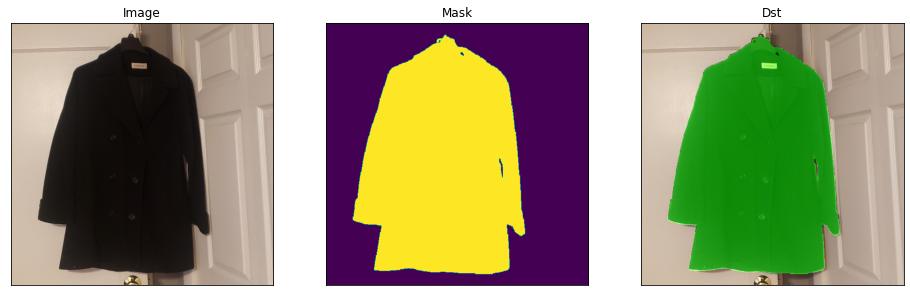

In [134]:
predict('sample_images/Tops/Overcoat.jpeg')

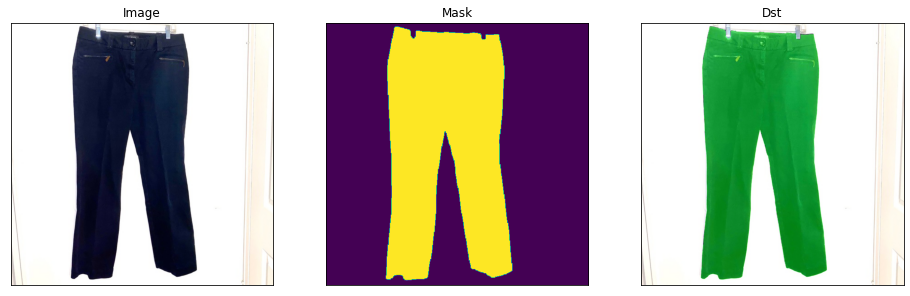

In [135]:
predict('sample_images/Bottoms/Chinos.jpeg')

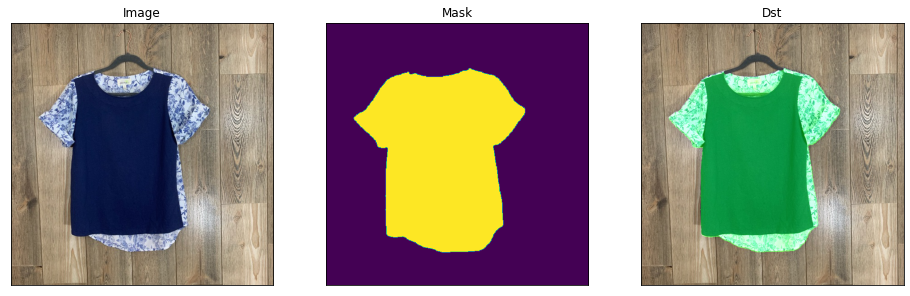

In [128]:
predict('sample_images/Tops/Printedtop.jpeg')